In [2]:
import cv2
import numpy as np
import pickle
import random
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import KFold
import optuna
import wandb
from sklearn.preprocessing import label_binarize
from sklearn.mixture import GaussianMixture
from skimage.feature import fisher_vector, learn_gmm

from utils import GeneralizedHistogramIntersection

/home/tda/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = [n[16:] for n in train_images_filenames]
test_images_filenames  = [n[16:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('MIT_split/test_labels.dat','rb'))

In [4]:
# VISUALIZATION OF IMAGES
def visualize_images(images, labels, idxs, num_cols, preds=None, show_gt_pred=False):
    num_img = len(idxs)
    num_rows = int(np.ceil(num_img/num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3))


    for i, idx in enumerate(idxs):
        row = i // num_cols
        col = i % num_cols

        # Load and display the image using PIL
        image = Image.open(images[idx])
        axes[row, col].imshow(image)

        axes[row, col].axis('off')
        if show_gt_pred:
            axes[row, col].set_title(f'({idx}) GT: {labels[idx]}, Pred:{preds[idx]}')
        else:
            axes[row, col].set_title(f'({idx}) {labels[idx]}')

    plt.tight_layout()
    plt.show()

In [5]:
# PLOTTING EVALUATION METRICS
def plot_eval(descriptor_name, evaluation_params, evaluations):
    figure, axis = plt.subplots(2, 2) 
    plt.figure(figsize=(8,8))

    if descriptor_name == "SIFT" or descriptor_name == "ORB":
        x_label = "n_features"
    else:
        x_label = "threshold"
    
    axis[0, 0].scatter(evaluation_params[descriptor_name], evaluations[descriptor_name][0])
    axis[0, 0].set_title(descriptor_name+" Accuracy") 
    axis[0, 0].set_ylim(0.2, 0.8)
    axis[0, 0].set_xticklabels([])
    axis[0, 1].scatter(evaluation_params[descriptor_name], evaluations[descriptor_name][1]) 
    axis[0, 1].set_title(descriptor_name+" Precision") 
    axis[0, 1].set_ylim(0.2, 0.8)
    axis[0, 1].set_xticklabels([])
    axis[1, 0].scatter(evaluation_params[descriptor_name], evaluations[descriptor_name][2]) 
    axis[1, 0].set_title(descriptor_name+" Recall") 
    axis[1, 0].set_ylim(0.2, 0.8)
    axis[1, 0].set_xlabel(x_label)
    axis[1, 1].scatter(evaluation_params[descriptor_name], evaluations[descriptor_name][3]) 
    axis[1, 1].set_title(descriptor_name+" F1-Score") 
    axis[1, 1].set_ylim(0.2, 0.8)
    axis[1, 1].set_xlabel(x_label)

    plt.subplots_adjust(hspace=50)
    plt.show() 

    def plot_eval_distances(distance, evaluation_params, evaluations):
        return
    
def plot_eval2(evaluations, min, max):
    figure, axis = plt.subplots(2, 2, figsize=(10, 8))

    x_label = "Parameter Value"

    evaluation_params = list(evaluations.keys())

    axis[0, 0].plot(evaluation_params, [value[0] for value in evaluations.values()], marker='o', label='Accuracy')
    axis[0, 0].set_title("Accuracy")
    axis[0, 0].set_ylim(min, max)
    axis[0, 0].set_xticks(evaluation_params)
    axis[0, 0].set_xticklabels([str(param) for param in evaluation_params], rotation=45, ha='right')
    axis[0, 0].legend()

    axis[0, 1].plot(evaluation_params, [value[1] for value in evaluations.values()], marker='o', label='Precision')
    axis[0, 1].set_title("Precision")
    axis[0, 1].set_ylim(min, max)
    axis[0, 1].set_xticks(evaluation_params)
    axis[0, 1].set_xticklabels([str(param) for param in evaluation_params], rotation=45, ha='right')
    axis[0, 1].legend()

    axis[1, 0].plot(evaluation_params, [value[2] for value in evaluations.values()], marker='o', label='Recall')
    axis[1, 0].set_title("Recall")
    axis[1, 0].set_ylim(min, max)
    axis[1, 0].set_xlabel(x_label)
    axis[1, 0].set_xticks(evaluation_params)
    axis[1, 0].set_xticklabels([str(param) for param in evaluation_params], rotation=45, ha='right')
    axis[1, 0].legend()

    axis[1, 1].plot(evaluation_params, [value[3] for value in evaluations.values()], marker='o', label='F1-Score')
    axis[1, 1].set_title("F1-Score")
    axis[1, 1].set_ylim(min, max)
    axis[1, 1].set_xlabel(x_label)
    axis[1, 1].set_xticks(evaluation_params)
    axis[1, 1].set_xticklabels([str(param) for param in evaluation_params], rotation=45, ha='right')
    axis[1, 1].legend()

    plt.subplots_adjust(hspace=0.4)
    plt.show()

def plot_test_eval(test_labels, predictions):
    class_labels = ['coast', 'forest', 'highway', 'inside_city', 'mountain', 'Opencountry', 'street', 'tallbuilding']
    y_bin = label_binarize(test_labels, classes=class_labels)
    predictions_bin = label_binarize(predictions, classes=class_labels)

    # Compute precision-recall curve, average precision, ROC curve, and AUC for each class
    precision, recall, pr_auc = dict(), dict(), dict()
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(len(class_labels)):
        # Precision-Recall Curve
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions_bin[:, i])
        pr_auc[i] = average_precision_score(y_bin[:, i], predictions_bin[:, i])

        # ROC Curve
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot precision-recall and ROC curves
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    axes[0].set_title('Precision-Recall Curves')
    for i in range(len(class_labels)):
        pr_display = PrecisionRecallDisplay(precision=precision[i], recall=recall[i], average_precision=pr_auc[i], estimator_name=f'Class {class_labels[i]}')
        pr_display.plot(ax=axes[0])

    axes[1].set_title('ROC Curves')
    for i in range(len(class_labels)):
        roc_display = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {class_labels[i]}')
        roc_display.plot(ax=axes[1])

    axes[2].set_title('Confusion matrix')
    confusion_m = confusion_matrix(test_labels, predictions, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_m, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d', ax=axes[2], xticks_rotation='vertical')  # You can customize colormap and value format

    plt.tight_layout()
    plt.show()


In [6]:
def initialize_descriptor(descriptor_name, param):
    """
        Initialize the local descriptor
    """
    if descriptor_name == 'SIFT' or 'dense_SIFT':
        descriptor = cv2.SIFT_create(nfeatures=param)
    elif descriptor_name == 'KAZE':
        descriptor = cv2.KAZE_create(threshold=param)
    elif descriptor_name == 'AKAZE':
        descriptor = cv2.AKAZE_create(threshold=param)
    elif descriptor_name == 'ORB':
        descriptor = cv2.ORB_create(nfeatures=param)
    elif descriptor_name == 'BRISK':
        descriptor = cv2.BRISK_create(thresh=param, octaves=0)
    else:
        descriptor = None
    return descriptor

def create_spatial_pyramid_descriptors(img, descriptor_name, descriptor, step_size, scale_factor, pyramid_level):
    """
        Given an image and a local descriptor, create the feature vector using a spatial pyramid scheme
    """
    # Compute the descriptors for the whole image
    image_descriptor = []
    if descriptor_name == 'dense_SIFT':
        keypoints = []
        for y in range(0, img.shape[0], step_size):
            for x in range(0, img.shape[1], step_size):
                keypoints.append(cv2.KeyPoint(x, y, scale_factor))
        kpt,des = descriptor.compute(img, keypoints)
    else:
        kpt,des = descriptor.detectAndCompute(img,None)
    image_descriptor.append(des)
    
    # SPATIAL PYRAMID
    # If the pyramid level is greater than 0, we divide the image into blocks (2x2 for level 1, 4x4 for level 2, etc.)
    # and compute the descriptors for each one. The final descriptor for the image will be the concatenation of all these 
    # descriptors
    for level in range(1, pyramid_level+1):
        block_grid_size = 2*level # Size of the block grid (block_grid_size x block_grid_size)
        block_height, block_width = int(img.shape[0]/block_grid_size), int(img.shape[1]/block_grid_size)
        
        if descriptor_name == 'dense_SIFT':
            # The keypoints are shared among all the blocks of the same level. (Dense SIFT uses a fixed grid of points)
            current_block_keypoints = []
            for y in range(0, block_height, step_size):
                for x in range(0, block_width, step_size):
                    current_block_keypoints.append(cv2.KeyPoint(x, y, scale_factor))
                    
        for f_h in range(block_grid_size):
            shift_h = f_h*block_height
            for f_w in range(block_grid_size):
                shift_w = f_w*block_width
                # Create block
                block = img[shift_h:shift_h+block_height, shift_w:shift_w+block_width]
                if descriptor_name == 'dense_SIFT':
                    _, des = descriptor.compute(block, current_block_keypoints)
                else:
                    _, des = descriptor.detectAndCompute(block, None)

                image_descriptor.append(des)
    return image_descriptor

def compute_descriptors(descriptor_name, descriptor, images_filenames, labels, step_size=0, scale_factor=0, pyramid_level=0):
    """
        Given a list of images, compute their descriptors.
    """
    descriptors = []
    label_per_descriptor = []

    for filename,labels in zip(images_filenames, labels):
        gray=cv2.cvtColor(cv2.imread(filename) ,cv2.COLOR_BGR2GRAY)
        image_descriptor = create_spatial_pyramid_descriptors(gray, descriptor_name, descriptor, step_size, scale_factor, pyramid_level)
        descriptors.append(image_descriptor)
        label_per_descriptor.append(labels)

    return descriptors, label_per_descriptor

def compute_visual_words(codebook, image_descriptors, k):
    """
        Compute the visual words histograms of all the regions and concatenate them
    """
    all_data_visual_words=np.zeros((len(image_descriptors), k*len(image_descriptors[0])), dtype=np.float32)
    for i in range(len(image_descriptors)):
        pyramid_descriptor = image_descriptors[i]
        words=np.zeros(k*len(pyramid_descriptor), dtype=np.float32)
        for d in range(len(pyramid_descriptor)):
            prediction = codebook.predict(pyramid_descriptor[d])
            words[d*k:d*k+k] = np.bincount(prediction, minlength=k)

        all_data_visual_words[i,:] = words

    return all_data_visual_words

def predict_visual_words(descriptor_name, codebook, test_images_filenames, descriptor, k_codebook, step_size=0, 
                         scale_factor=0, transformer_normalization=None, transformer_scalation=None, dim_red_object=None, pyramid_level=0, num_blocks=1):
    """
        For each image, create descriptors and compute the visual words histogram.
    """
    # Number of features of the final image descriptor
    feature_size = k_codebook*num_blocks if not dim_red_object else dim_red_object.n_components
    visual_words_test=np.zeros((len(test_images_filenames), feature_size),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        gray=cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2GRAY)
        image_descriptor = create_spatial_pyramid_descriptors(gray, descriptor_name, descriptor, step_size, scale_factor, pyramid_level)
        visual_words = compute_visual_words(codebook, [image_descriptor], k_codebook)

        if transformer_normalization is not None:
            visual_words = transformer_normalization.transform(visual_words)
        elif transformer_scalation is not None:
            visual_words = transformer_scalation.transform(visual_words)
        # Apply the dimensionality reduction algorithm if necessary
        if dim_red_object:
            visual_words = dim_red_object.transform(visual_words)
        visual_words_test[i, :] = visual_words[0, :]
        
    return visual_words_test   

def evaluate(predictions, test_labels):
    confusion_m = confusion_matrix(test_labels, predictions)
    confusion_m_fp = np.triu(confusion_m, k=1)
    FP = sum(confusion_m_fp.sum(axis=0))
    confusion_m_fn = np.tril(confusion_m, k=-1)
    FN = sum(confusion_m_fn.sum(axis=1))
    TP = sum(np.diag(confusion_m))
    TN = confusion_m.sum() - (FP + FN + TP)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*(precision*recall)/(precision+recall)
    return accuracy, precision, recall, f1_score

def create_model(config):
    """
        Initialize the classifier model given a config dictionary.
    """
    if config["model_type"] == "knn":
        model = KNeighborsClassifier(n_neighbors=config['k_neigh'], n_jobs=-1, metric=config['distance'])
    elif config["model_type"] == "svm":
        if config["kernel"] == "linear":
            model = SVC(
                class_weight='balanced',
                C=config["C"],
                kernel=config["kernel"])
        elif config["kernel"] == "rbf":
            model = SVC(
                class_weight='balanced',
                C=config["C"], 
                gamma=config["gamma"],
                kernel=config["kernel"])
        elif config["kernel"] == "histogram_intersection":
            model = SVC(
                class_weight='balanced',
                kernel=GeneralizedHistogramIntersection(alpha=config["alpha"]),
                C=config["C"])
        else:
            assert config["kernel"] in ["linear", "rbf", "histogram_intersection"], "Invalid Kernel"

    elif config["model_type"] == "logistic_regression":
        model = LogisticRegression(
            class_weight='balanced',
            penalty=config["penalty"], 
            C=config["C"], 
            fit_intercept=config["fit_intercept"],
            solver=config['solver'],
            max_iter=500)
    else:
        assert config["model_type"] in ["knn", "svm", "logistic_regression"], "Invalid Model Type"
    return model

def train_model(train_images_filenames, train_labels, test_images_filenames, test_labels, config, return_predictions=False):
    """
        Function that preprocesses the input data, trains the model and returns a series of scores and the predictions if 
        required.
    """
    descriptor = initialize_descriptor(config['descriptor'], config['descriptor_param'])
    Train_descriptors, Train_label_per_descriptor = compute_descriptors(
        config['descriptor'], descriptor, train_images_filenames, 
        train_labels, config['step_size'], config['scale_factor'], 
        pyramid_level=config["pyramid_level"]
        )
    
    # For creating the codebook, we only use the level 0 descriptors (Descriptors of the 
    # whole images)
    D=np.vstack([des[0] for des in Train_descriptors])
    codebook = MiniBatchKMeans(n_clusters=config['k_codebook'], verbose=False, batch_size=config['k_codebook'] * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    visual_words = compute_visual_words(codebook, Train_descriptors, config['k_codebook'])

    # Apply normalization/scaling if necessary
    if config['normalize']:
        transformer_normalization = Normalizer().fit(visual_words)
        visual_words = transformer_normalization.transform(visual_words)
    else:
        transformer_normalization = None
    if config['scale']:
        transformer_scalation = StandardScaler().fit(visual_words)
        visual_words = transformer_scalation.transform(visual_words)
    else:
        transformer_scalation = None

    # Apply the dimensionality reduction algorithm if necessary
    if config['dim_reduction'] == "pca":
        dim_red_object = PCA(n_components=config['n_components'])
        dim_red_object.fit(visual_words, Train_label_per_descriptor)
        visual_words = dim_red_object.transform(visual_words)
    elif config['dim_reduction'] == "lda":
        #if config['n_components'] > 7:
        #    config['n_components'] = 7 # TODO
        dim_red_object = LinearDiscriminantAnalysis(n_components=max(1,config['n_components']%8))
        dim_red_object.fit(visual_words, Train_label_per_descriptor)
        visual_words = dim_red_object.transform(visual_words)
    else:
        dim_red_object = None
    
    # Initialize and train classifier model object
    model = create_model(config)
    model.fit(visual_words, train_labels) 

    # Inference phase: Compute viusal words for the test split, get predictions and evaluate the performance.
    visual_words_test = predict_visual_words(config['descriptor'], codebook, test_images_filenames, descriptor, config['k_codebook'], 
                                             config['step_size'], config['scale_factor'], transformer_normalization, 
                                             transformer_scalation, dim_red_object, pyramid_level=config["pyramid_level"], num_blocks = len(Train_descriptors[0]))
    predictions = model.predict(visual_words_test)
    accuracy, precision, recall, f1_score = evaluate(predictions, test_labels)
    
    if return_predictions:
        return accuracy, precision, recall, f1_score, predictions
    else:
        return accuracy, precision, recall, f1_score

In [7]:
def cross_validation(train_images_filenames, train_labels, config):
    """
        Implementation of the cross-validation method
    """
    # Change type from list to np.array
    train_images_filenames = np.array(train_images_filenames)
    train_labels = np.array(train_labels)

    # Split training data into n_splits
    kf = KFold(n_splits=config['n_folds'], shuffle=True, random_state=111)

    # Initialize vectors to store metrics of each fold
    accuracies, recalls, precisions, f1s = [], [], [], []

    # Iterate through each fold
    for train_index, test_index in kf.split(train_images_filenames):
        # Split training and test for the current fold
        X_train, X_test = train_images_filenames[train_index], train_images_filenames[test_index]
        y_train, y_test = train_labels[train_index], train_labels[test_index]

        # Fit models for this fold
        accuracy, precision, recall, f1_score = train_model(X_train, y_train, X_test, y_test, config)
        # Store metrics
        accuracies.append(accuracy)
        recalls.append(precision)
        precisions.append(recall)
        f1s.append(f1_score)

    return np.mean(accuracies), np.mean(recalls), np.mean(precisions), np.mean(f1s)

In [8]:
def test_model(train_images_filenames, train_labels, test_images_filenames, test_labels, config):
    """
        Given a configuration and the train/test splits, fit the model and return performance/predictions.
    """
    # Change type from list to np.array
    X_train = np.array(train_images_filenames)
    y_train = np.array(train_labels)

    X_test = np.array(test_images_filenames)
    y_test = np.array(test_labels)

    # Fit models for this fold
    accuracy, precision, recall, f1_score, predictions = train_model(X_train, y_train, X_test, y_test, config, return_predictions=True)

    return accuracy, precision, recall, f1_score, predictions

### 0. Visualize data

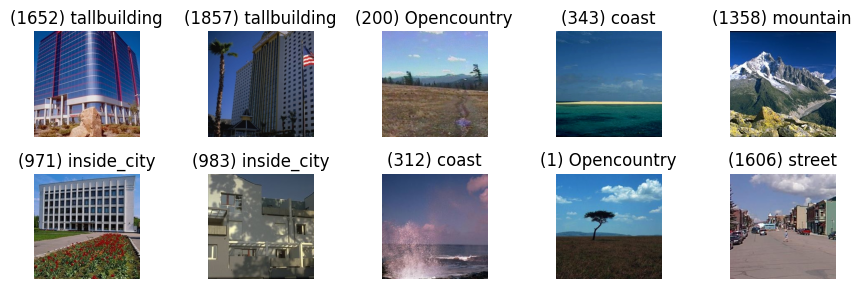

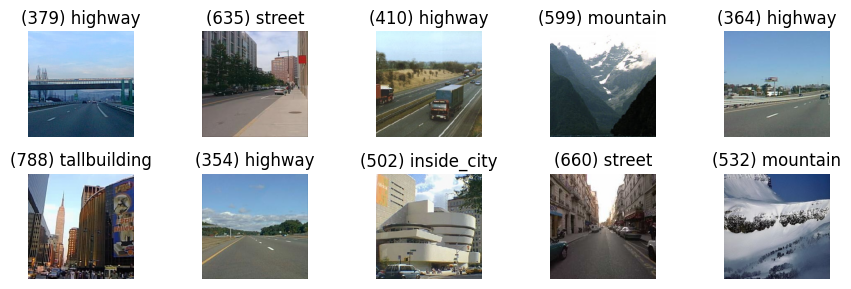

In [11]:
num_samples = 10

all_indices_train = list(range(len(train_images_filenames)))
random_indices_train = random.sample(all_indices_train, num_samples)
visualize_images(train_images_filenames, train_labels, random_indices_train, 5)

all_indices_test = list(range(len(test_images_filenames)))
random_indices_test = random.sample(all_indices_test, num_samples)
visualize_images(test_images_filenames, test_labels, random_indices_test, 5)

### 1. Choosing the best descriptor

The first step in the development of the full model is to compute and test the different types of possible descriptors. In this case, we are considering SIFT, KAZE, AKAZE, ORB and BRISK and study how the nfeatures parameter infuence each of them.

In [12]:
evaluations = {}
descriptors = ['SIFT', 'KAZE', 'AKAZE', 'ORB', 'BRISK']
evaluation_params = {'SIFT': [100, 250, 500, 750, 1000, 1250, 1500], 'KAZE': [0.00005, 0.00001, 0.000005, 0.000001, 0.0000005, 0.0000001, 0.00000005, 0.00000001],'AKAZE': [0.00005, 0.00001, 0.000005, 0.000001, 0.0000005, 0.0000001, 0.00000005, 0.00000001], 'ORB': [100, 250, 500, 750, 1000, 1250, 1500], 'BRISK': [2, 4, 8, 10, 14, 18, 22]}

for i in range (len(descriptors)):
    descriptor_name = descriptors[i]
    evaluations[descriptor_name] = [[], [], [], []]
    for param in evaluation_params[descriptor_name]:

        config = {
            'descriptor': descriptor_name,
            'descriptor_param': param,
            'k_codebook': 128,
            'step_size': 0,
            'scale_factor': 0,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
        accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
        
        evaluations[descriptor_name][0].append(accuracy)
        evaluations[descriptor_name][1].append(precision)
        evaluations[descriptor_name][2].append(recall)
        evaluations[descriptor_name][3].append(f1_score)

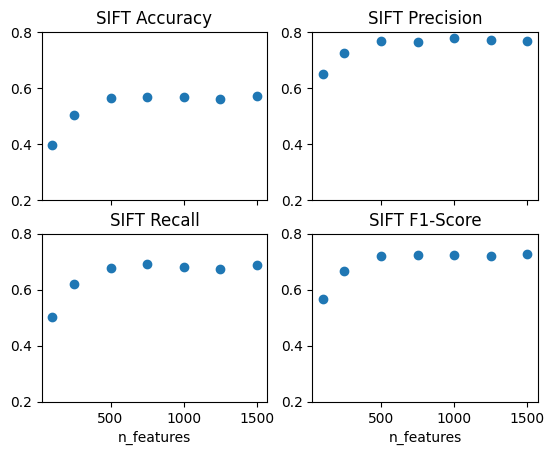

<Figure size 800x800 with 0 Axes>

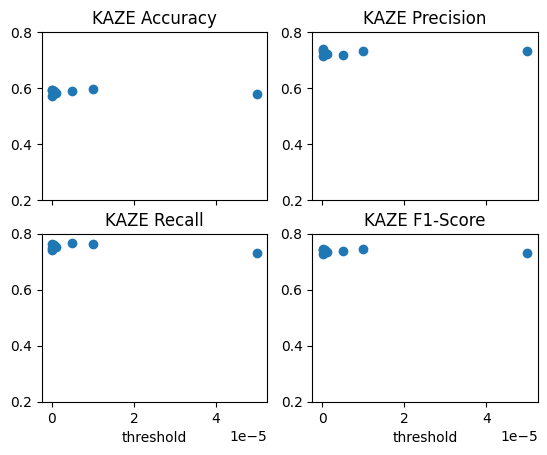

<Figure size 800x800 with 0 Axes>

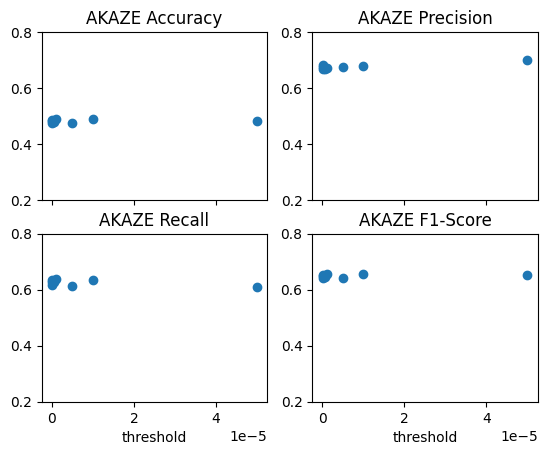

<Figure size 800x800 with 0 Axes>

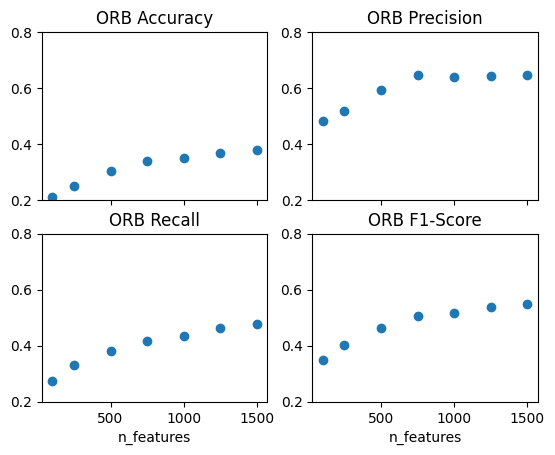

<Figure size 800x800 with 0 Axes>

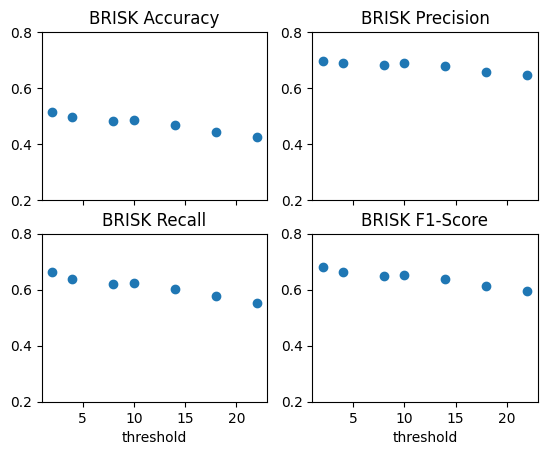

<Figure size 800x800 with 0 Axes>

In [54]:
for descriptor_name in descriptors:
    plot_eval(descriptor_name, evaluation_params, evaluations)                                                                    

After the execution of the previous code we obtain 5 sets of the 4 evaluated metrics, that are accuracy, precision, recall and f1-score. Each set belongs to each descriptor compared in this study. 

Every metric provides us with similar information of the model and for this example we will compare the F1-score, since it is the measure of the predictive performance that encompasses precision and recall, that is, that gives more information in one single metric. Also, for this example the obtained results, i.e. the plots, are similar and almost proportional between metrics. 

As we can observe, as we increase the number of features or decrease the threshold we obtain better performance. The F1-score for each descriptor, ordered from highest to lowest value, is 74,6%, 72,6%, 68%, 65,6% and 54,8% for the KAZE, SIFT, BRISK, AKAZE and ORB, respectively. We will focus on the first two: SIFT and KAZE and we will study the optimal parameters of n_features and threshold in order to obtain the best descriptor. 

In [9]:
wandb.login()

True

In [75]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for the support vector machine
    n_features = trial.suggest_int('n_features', 50, 2000)

    config = {
            'descriptor': 'SIFT',
            'descriptor_param': n_features,
            'k_codebook': 128,
            'step_size': 0,
            'scale_factor': 0,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10, 
            'normalize': False, 
            'scale': False,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # accuracy, precision, recall, f1_score = knn_model('SIFT', n_features, 128, train_images_filenames, train_labels, test_images_filenames, test_labels)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'n_features': n_features, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='SIFT n_features optimization', settings=wandb.Settings(start_method="fork"))

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-Score: ', best_trial.value)
print('Params: ', best_trial.params)


[I 2023-12-30 22:03:49,570] A new study created in memory with name: no-name-6cf43e9a-4dea-45aa-a152-c59c582e02a2
[I 2023-12-30 22:06:45,848] Trial 0 finished with value: 0.7234926827432042 and parameters: {'n_features': 579}. Best is trial 0 with value: 0.7234926827432042.
[I 2023-12-30 22:09:47,302] Trial 1 finished with value: 0.723395982990007 and parameters: {'n_features': 1691}. Best is trial 0 with value: 0.7234926827432042.
[I 2023-12-30 22:12:45,278] Trial 2 finished with value: 0.7248472751321211 and parameters: {'n_features': 1839}. Best is trial 2 with value: 0.7248472751321211.
[I 2023-12-30 22:15:44,884] Trial 3 finished with value: 0.73002318193568 and parameters: {'n_features': 1213}. Best is trial 3 with value: 0.73002318193568.
[I 2023-12-30 22:18:41,587] Trial 4 finished with value: 0.7249161088298549 and parameters: {'n_features': 1148}. Best is trial 3 with value: 0.73002318193568.
[I 2023-12-30 22:21:41,358] Trial 5 finished with value: 0.7191647534382282 and para

Best trial:
F1-Score:  0.7335301322561535
Params:  {'n_features': 771}


The following plot shows the accuracy, precision, recall and f1-score values through the evolution of the n_features parameter for the SIFT descriptor. As we can observe, the evaluation parameters values increase as the number of features increases. This means that the higher the number of features per image, the better will be the prediction. The main problem is that as we increase the number of features, the computational cost is also increased, so we would like also to minimize this number of features in order to obtain an accurated and fast training and prediction.

In this case, the maximum value of f1-score 77.98% is reached with 771 features. The accuracy, precision and recall are 57.95%, 77.98% and 69.31%, respectively. We can obtain these numbers if we look at the wandb dashboard on https://wandb.ai.

<div style="text-align:center">
    <img src="img/SIFT_n_features.png" width="700" height="300" alt="Description">
</div>



In [76]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for the support vector machine
    threshold = trial.suggest_float('threshold', 0.0000005, 0.0005)

    config = {
            'descriptor': 'KAZE',
            'descriptor_param': threshold,
            'k_codebook': 128,
            'step_size': 0,
            'scale_factor': 0,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config) 

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'threshold': threshold, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='KAZE threshold optimization', settings=wandb.Settings(start_method="fork"))

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-score: ', best_trial.value)
print('Params: ', best_trial.params)

accuracy,████████▅██▇███▁██████████▇██▇██▆███▇█▇█
f1-score,████████▅██▇███▁██████████▇█████▆███▇███
n_features,▃▇█▆█▆▇▄▁▄▄▂▃▄▃▁▅▆▆▄▇▆▅▃▃▄▂▃▅▄▄▃▂▄▃▅▂▄▃▅
precision,██▇██▇▇▇▅██▆█▇█▁█▇▇██▇▇██▇▇█▇▇██▆███▇▇▇█
recall,████████▅██▇▇██▁███████▇▇█▇█████▆███▇▇▇█
accuracy,0.57257
f1-score,0.72795
n_features,1093
precision,0.77492
recall,0.68797


[I 2023-12-31 00:28:28,908] A new study created in memory with name: no-name-bb3f1b0a-56c8-471a-9029-e29401e61df7
[I 2023-12-31 00:35:56,187] Trial 0 finished with value: 0.7113585571394634 and parameters: {'threshold': 0.00016460830100081431}. Best is trial 0 with value: 0.7113585571394634.
[I 2023-12-31 00:42:59,657] Trial 1 finished with value: 0.6717396227486085 and parameters: {'threshold': 0.00041151928727794986}. Best is trial 0 with value: 0.7113585571394634.
[I 2023-12-31 00:50:16,894] Trial 2 finished with value: 0.6961858206633679 and parameters: {'threshold': 0.00023259461500433698}. Best is trial 0 with value: 0.7113585571394634.
[I 2023-12-31 00:57:30,523] Trial 3 finished with value: 0.6943518246362351 and parameters: {'threshold': 0.00024187621495265566}. Best is trial 0 with value: 0.7113585571394634.
[I 2023-12-31 01:04:41,473] Trial 4 finished with value: 0.6917095133925796 and parameters: {'threshold': 0.0002804376368360037}. Best is trial 0 with value: 0.7113585571

Best trial:
F1-score:  0.7465289641456253
Params:  {'threshold': 2.5943126554705387e-05}


For the KAZE descriptor, the maximum value of f1-score 74.65% is reached with a threshold of 0.000025943. It make sense to think that as long as we decrease the threshold value, the f1-score increases, meaning that we have more number of features to compare of each image and more accurated predictions. The accuracy precision and recall for this solution are 59.65%, 74.16% and 75.27%, respectively. We can obtain these numbers if we look at the wandb dashboard on https://wandb.ai.

<div style="text-align:center">
    <img src="img/KAZE_threshold.png" width="700" height="300" alt="Description">
</div>

After the parameter optimization of the SIFT and KAZE descriptors we can affirm that KAZE outperforms SIFT. The former obtained a F1-score of 75.27 and the latter 73.35% with a threshold number and number of features of 0.000025943 and 771 respectively. Even if KAZE obtained the best results, the execution time is by far more expensive regarding SIFT and, since the evaluation results are considerably similar, **SIFT descriptor is preferred**. We can find one comparison plot of the evolution of parameters for both descriptors through optuna steps below.

<div style="text-align:center">
    <img src="img/SIFTKAZE_scoreevolution.png" width="700" height="300" alt="Description">
</div>

### 2. Using dense_SIFT

In [7]:
config = {
            'descriptor': 'SIFT',
            'descriptor_param': 771,
            'k_codebook': 128,
            'step_size': 0,
            'scale_factor': 0,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
print("SIFT accuracy, precision, recall and F1-score", cross_validation(train_images_filenames, train_labels, config))
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 128,
            'step_size': 5,
            'scale_factor': 10,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
print("Dense SIFT accuracy, precision, recall and F1-score",cross_validation(train_images_filenames, train_labels, config))

SIFT accuracy, precision, recall and F1-score (0.5794748395812226, 0.7798496988085577, 0.6931152272389346, 0.7335301322561535)
Dense SIFT accuracy, precision, recall and F1-score (0.7496088033322076, 0.8524260239491979, 0.8622992732917432, 0.8567396722879155)


|      | SIFT | dense_SIFT      |
|----------|-----|-----------------|
| Accuracy     | 57.94  | 74.96 |
| Precision     | 77.98  | 85.24  |
| Recall      | 69.31  | 86.23 |
| F1-score      | 73.35  | 85.67        |

Here we find one table showing the accuracy, precision, recall and f1-score of the SIFT descriptor (our SOTA up to now) compared to the dense SIFT descriptor with step size and scale factor randomly chosen. The use of a grid of descriptors uniformly distributed every (_stepsize_ x _stepsize_) in the image performs better results than focusing on the main descriptors that the SIFT algorithm computes automatically. This can be explained because of the fact that if we focus on the main automatic descriptors, we are losing spatial information and information of how many shapes and colors there are in the image. For example, we could determine the image refers to a beach if we focus on three big groups of descriptors: sky, sea and sand. 

The next step is to optimize the step size and the scale factor. 


In [8]:
# Define the objective function (classification accuracy)
def objective(trial):
    step_size = trial.suggest_int('step_size', 1, 100)
    scale_factor = trial.suggest_int('scale_factor', 2, 20)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 128,
            'step_size': step_size,
            'scale_factor': scale_factor,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'step_size': step_size, 'scale_factor':scale_factor, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='dense_SIFT step_size and scale_factor optimization', settings=wandb.Settings(start_method="fork"))

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-score: ', best_trial.value)
print('Params: ', best_trial.params)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ainoacontreras (tfgainoa). Use `wandb login --relogin` to force relogin


[I 2023-12-31 11:18:38,692] A new study created in memory with name: no-name-01950a35-1796-4260-aa19-d172f364031c
[I 2023-12-31 11:19:31,293] Trial 0 finished with value: 0.7434500927374608 and parameters: {'step_size': 88, 'scale_factor': 20}. Best is trial 0 with value: 0.7434500927374608.
[I 2023-12-31 11:21:41,251] Trial 1 finished with value: 0.8553932390041495 and parameters: {'step_size': 10, 'scale_factor': 8}. Best is trial 1 with value: 0.8553932390041495.
[I 2023-12-31 11:22:30,560] Trial 2 finished with value: 0.7470764180973044 and parameters: {'step_size': 20, 'scale_factor': 2}. Best is trial 1 with value: 0.8553932390041495.
[I 2023-12-31 11:23:23,563] Trial 3 finished with value: 0.7930952902594088 and parameters: {'step_size': 52, 'scale_factor': 14}. Best is trial 1 with value: 0.8553932390041495.
[I 2023-12-31 11:24:09,938] Trial 4 finished with value: 0.7320731950020299 and parameters: {'step_size': 67, 'scale_factor': 11}. Best is trial 1 with value: 0.85539323900

: 

: 

After optimizing the search using optuna, we concluded with a **step size of 10** and a **scale factor of 8** as the best parameters for the dense SIFT descriptor with accuracy, precision, recall and f1-score values of 74.80%, 85.31%, 85.94% and 85.54%, respectively. There is a trade-off in the step size selection, since smaller the step, the more information we get from the image, and we could think that a step size of 1 might be the best option. This is not a good idea because we are focusing too much on small details and, furthermore, the computational cost increases. 

### 3. Normalizing data

In [10]:
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 128,
            'step_size': 10,
            'scale_factor': 8,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': True,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
print("Normalized dense SIFT accuracy, precision, recall and F1-score",cross_validation(train_images_filenames, train_labels, config))

Normalized dense SIFT accuracy, precision, recall and F1-score (0.7336541708882135, 0.8585998472946464, 0.8352836238343114, 0.8460717436911208)



|      | Dense SIFT | Normalized dense SIFT      |
|----------|-----|-----------------|
| Accuracy     | 74.80  | 73.37 |
| Precision     | 85.31  | 85.86  |
| Recall      | 85.94  | 83.28 |
| F1-score      | 85.54  | 84.61        |

### 3. Scaling data

In [11]:
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 128,
            'step_size': 10,
            'scale_factor': 8,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': True,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
print("Scaled dense SIFT accuracy, precision, recall and F1-score",cross_validation(train_images_filenames, train_labels, config))

Scaled dense SIFT accuracy, precision, recall and F1-score (0.7697962400090059, 0.8849943347061956, 0.8561928172863198, 0.8697151690289584)



|      | Dense SIFT | Scaled dense SIFT      |
|----------|-----|-----------------|
| Accuracy     | 74.80  | 76.98 |
| Precision     | 85.31  | 88.50  |
| Recall      | 85.94  | 85.62 |
| F1-score      | 85.54  | 86.97        |

As we have seen, to normalize or scale the visual words does not improve the model. The performance for the non-normalized and non-scaled model is similar to the normalized model and the scaled model. There are many reasons that can explain this results and some of them can be found below. 
* inherently insensitive algorithm 
* features already within a similar range naturally
* improvement gained from normalization or scaling might be overshadowed by other hyperparameters or aspects of the model that need tuning
* normalization or scaling might not be sufficient (non-Gaussian data or it has outliers)
* inappropriate scaling/normalization method


### 4. Influence of codebook sizes k

After computing the descriptors, we cluster the feature space using a clustering algorithm. For our model, we have used the k-means algorithm being k the codebook size (number of visual words we will use).

We compute the accuracy and average precision, recall and f1-score with 10 (stratified) fold cross-validation to tune the parameter codebook size.

In [12]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for codebook sizes k
    k_codebook = trial.suggest_int('k_codebook', 50, 400)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': k_codebook,
            'step_size': 10,
            'scale_factor': 8,
            'k_neigh': 5,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None, 
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'k': k_codebook, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='dense_SIFT codebook size (k) optimization')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


[I 2023-12-31 13:47:09,877] A new study created in memory with name: no-name-6f7706ca-a307-4c16-9889-15215ca39fc8
[I 2023-12-31 13:49:11,174] Trial 0 finished with value: 0.8548886272953116 and parameters: {'k_codebook': 92}. Best is trial 0 with value: 0.8548886272953116.
[I 2023-12-31 13:51:40,349] Trial 1 finished with value: 0.8420913821733607 and parameters: {'k_codebook': 309}. Best is trial 0 with value: 0.8548886272953116.
[I 2023-12-31 13:54:17,951] Trial 2 finished with value: 0.8479345117221373 and parameters: {'k_codebook': 366}. Best is trial 0 with value: 0.8548886272953116.
[I 2023-12-31 13:56:50,433] Trial 3 finished with value: 0.8557156654182417 and parameters: {'k_codebook': 340}. Best is trial 3 with value: 0.8557156654182417.
[I 2023-12-31 13:59:07,151] Trial 4 finished with value: 0.852962407695863 and parameters: {'k_codebook': 248}. Best is trial 3 with value: 0.8557156654182417.
[I 2023-12-31 14:01:07,437] Trial 5 finished with value: 0.8500304140081388 and par

Best trial:
F1-score:  0.8628490437148878
Params:  {'k_codebook': 348}


accuracy,▅▁▃▆▄▄▅▇▅▅▄▅▃▆▇▄▅▇▆▃▆▅▃▆▄▅▆▅▅▄▆▆▂▇▆█▇▅▅▃
f1-score,▅▁▃▆▄▄▅▇▅▅▄▅▃▆▇▄▅▇▆▄▆▅▃▇▄▅▆▅▅▄▆▆▂▇▆█▇▅▅▃
k,▂▆▇▇▁▇▂▆▄▆▆▄█▇▅▃▄▆▄▆▄▅█▆▅▆▆▇▆▇▅▇▁▆▆▇██▇▇
precision,█▁▄▄▆▅▆█▇▆▅▆▅▇▇▆▆█▆▅▆▅▄▇▄▅▆▅▇▅▇▆▇█▆▅▇▄▅▆
recall,▃▄▄▆▃▄▄▅▄▄▄▄▄▅▅▄▄▅▅▄▅▅▄▅▅▅▅▅▄▄▅▅▁▅▅█▆▅▅▃
accuracy,0.73736
f1-score,0.84821
k,361
precision,0.84995
recall,0.84786


From the plot below, we can see that there is not much difference in the evaluation metrics for all the amounts of codebook sizes tested. Nevertheless, the best results are obtained with a codebook size of 348 (where there a big peak in the recall) with a bit more than 86% of f1-score and more than 88% of recall. In the plot below we can observe two slight but relevant behaviors: on the one hand, with small codebook sizes (less than 100), the curves are quite flat and the visual words tend to be too general so they are not representative enough to perform classification properly; on the other hand, with large codebook sizes, the curves have much more abrupt changes so the visual words are too specific, so the features are splitted into irrelevant details which leads to decrease in the performance.

<div style="text-align:center">
    <img src="img/DENSESIFT_kcodebook.png" width="700" height="300" alt="Description">
</div>

### 5. Influence of value for k-neighbors in k-nn classifier

Now that we have been able to grouped our descriptors into similar groups, it's time to build a k-nn classifier and train it cross-validated with the train descriptors.

First, we will start selecting the optimal amount of neighbours the model will use to make decisions (this is the k parameter).

In [13]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for codebook sizes k
    k_neigh = trial.suggest_int('k_neigh', 2, 100)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'k_neigh': k_neigh,
            'distance': 'euclidean',
            'n_folds': 10,
            'normalize': None,
            'scale': None, 
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # accuracy, precision, recall, f1_score = knn_model('dense_SIFT', 663, ?, train_images_filenames, train_labels, test_images_filenames, test_labels, step_size=10, scale_factor=13, k_neigh=k_neigh)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'k_neigh': k_neigh, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='dense_SIFT k neighbors optimization')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


[I 2023-12-31 16:02:30,607] A new study created in memory with name: no-name-f24f41db-3441-4393-a1fb-5970155cb39f
[I 2023-12-31 16:05:12,483] Trial 0 finished with value: 0.8355466803023752 and parameters: {'k_neigh': 94}. Best is trial 0 with value: 0.8355466803023752.
[I 2023-12-31 16:07:52,236] Trial 1 finished with value: 0.8470398924439673 and parameters: {'k_neigh': 43}. Best is trial 1 with value: 0.8470398924439673.
[I 2023-12-31 16:10:33,134] Trial 2 finished with value: 0.8306001412718766 and parameters: {'k_neigh': 2}. Best is trial 1 with value: 0.8470398924439673.
[I 2023-12-31 16:13:15,289] Trial 3 finished with value: 0.8466427436538849 and parameters: {'k_neigh': 49}. Best is trial 1 with value: 0.8470398924439673.
[I 2023-12-31 16:15:53,937] Trial 4 finished with value: 0.8354450369573321 and parameters: {'k_neigh': 85}. Best is trial 1 with value: 0.8470398924439673.
[I 2023-12-31 16:18:34,763] Trial 5 finished with value: 0.8311359456936745 and parameters: {'k_neigh'

Best trial:
F1-score:  0.8627890667582255
Params:  {'k_neigh': 10}


accuracy,▂▅▁▄▁▃▂▇▇▁▇▇▆▇▅▄▄▇▇▅▆▇▇▅▄▇▆▅█▇▁█▇▁▇▇▂▇▇█
f1-score,▂▅▁▄▁▃▂▇▇▁▇▇▆▇▅▄▄▇▇▅▆▇▇▅▄▇▇▅█▇▁█▇▁▇▇▂▇▇█
k_neigh,█▄▁▄█▇█▁▁▁▃▃▃▃▄▅▅▂▂▄▃▂▂▄▄▃▂▃▁▂▁▁▁▁▂▂▇▂▂▂
precision,▁▃█▃▁▂▁▅▅█▄▄▃▄▃▂▂▄▅▃▃▅▄▃▃▄▄▃▅▅█▅▅█▅▄▂▄▄▅
recall,▇█▁▇▇█▇▇▇▁███████▇▇██▇▇█▇███▇▇▁▇▇▁▇▇█▇█▇
accuracy,0.75971
f1-score,0.86279
k_neigh,10
precision,0.83606
recall,0.89253


From the plot below, we can see two types of behaviour for the different evaluation metrics: for the majority (including accuracy, f1 and precision) we observe a small increase until we reach k=10 and then they start declining as we increase k. However the recall curve keeps more or less stable for any value of k. The conclusion is that we should choose k to be large enough so that the noise in the data is minimized, but small enough so that samples from other classes are not included. The best results are obtained with a when taking into account k=10 neighbours in the algorithm. 


<div style="text-align:center">
    <img src="img/DENSESIFT_kneighbors.png" width="700" height="300" alt="Description">
</div>

### 6. Influence of distances in k-nn classifier

We will continue by testing different metric distances for the KNN algorithm and selecting the optimal one.

In [ ]:
evaluations = {}
distances = ['euclidean', 'manhattan', 'minkowski', 'jaccard', 'hamming']

for i in range (len(distances)):
    distance_name = distances[i]
    evaluations[distance_name] = [[], [], [], []]
    print(distance_name)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'k_neigh': 10,
            'distance': distance_name,
            'n_folds': 10,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)

    evaluations[distance_name][0].append(accuracy)
    evaluations[distance_name][1].append(precision)
    evaluations[distance_name][2].append(recall)
    evaluations[distance_name][3].append(f1_score)

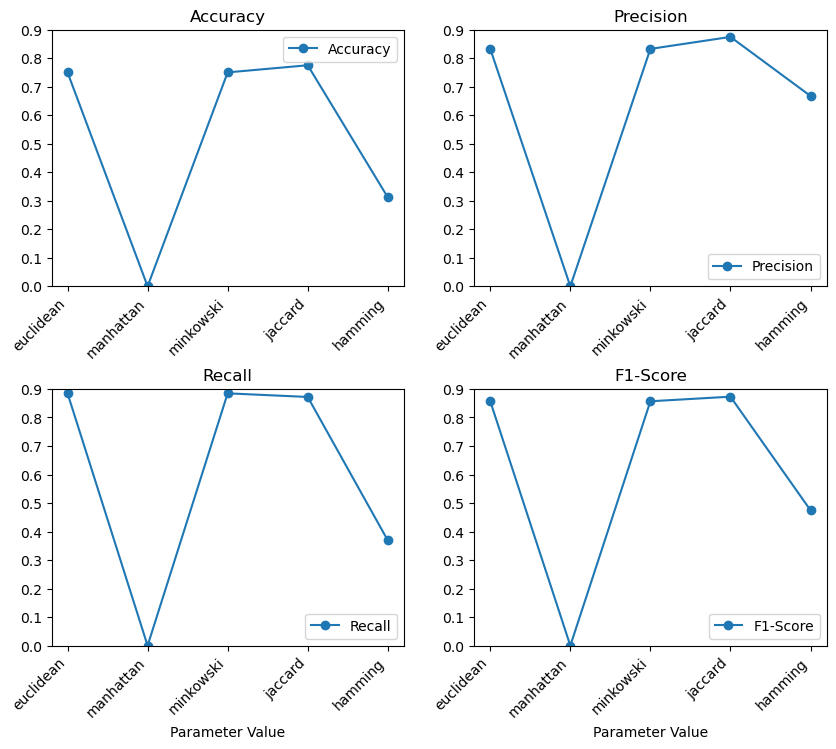

In [99]:
plot_eval2(evaluations, 0, 0.9)

Most of the distances worked in a similar way, except for Manhattan and Hamming.
We obtain the best results with Jaccard distance by a small margin between Minkowski and Euclidean (we have been able to improve the f1-score by slightly less than 2%).
Remark also that Minkowski and Euclidean obtained the same results since the default configuration of parameters of the first (p=2) make it perform as the second.

### 7. Cross-Validation

Until now, we have been using cross validation with 10 folds in order to optimize the different hyperparameters of the model. As it is a critical step to find the best possible model, we would like to check the influence of the number folds used in the cross validation in the results in order to find the best possible f1-score as possible. For this experiment, we will use the best combination of parameters until the moment.

In [ ]:
evaluations2 = {}
n_folds = range(2, 25, 2)

for i in n_folds:
    evaluations2[i] = [[], [], [], []]

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'k_neigh': 10,
            'distance': 'jaccard',
            'n_folds': i,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    print("Cross Validations with", i, "folds - acc:", accuracy, "prec:", precision, "rec:", recall, "f1:", f1_score)

    evaluations2[i][0].append(accuracy)
    evaluations2[i][1].append(precision)
    evaluations2[i][2].append(recall)
    evaluations2[i][3].append(f1_score)

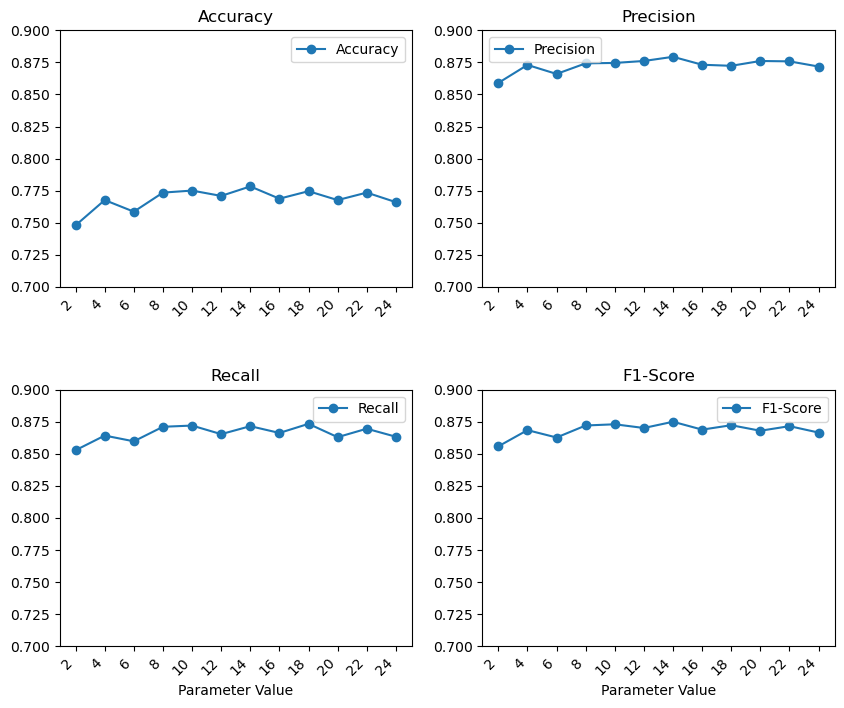

In [100]:
plot_eval2(evaluations2, 0.7, 0.9)

Most of the values performed really similar, with less than a 2,5% difference between all of them for all the evaluation metrics. So we can conclude that the number of folds use in the CV is not going to influence the f1-score we are obtaining from the model. However, an important and discriminative factor is the computational time: as the number of folds increase, also does it. For that reason we decided to use a small number of folds, in particular k=4.

### 8. Model selection 

Up until now we have been using KNN as the backbone of our classification model which, after the last experiment, has yield a F1-Score of 0.86842. The next step of this project is to try different types of model and choose the better performing one. For this purpose, we will explore Support Vector Machine models (using different kernels) and a logistic regression model.

We employ a 4-fold cross-validation and, again, we use Optuna for finding the best hyperparameter in an optimal way, aiming for around 25 trials per search, although we have found some problems regarding memory usage and non-convergence of the algorithm in some tests, that have forced us to stop earlier.

#### 8.1. SVM with linear kernel

The first SVM model that we will use is the one with a linear kernel, arguably the simplest one. This model only requires a single hyperparameter, a regularization parameter C, that we have set to have a very large range.

In [8]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for codebook sizes k
    C = trial.suggest_float('C', 0.001, 1000, step=None, log=True)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 4,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "svm",
            'C': C,
            'kernel': "linear",
            'pyramid_level': 0
        }
    
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'C': C, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3', name='svm_linear_2')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=25, n_jobs=-1)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

[I 2024-01-03 14:38:08,061] A new study created in memory with name: no-name-1e52d4c9-c6fa-4a54-8c2d-4b75f7062e2a
[I 2024-01-03 16:40:31,158] Trial 15 finished with value: 0.9059110033407073 and parameters: {'C': 0.04399637223059803}. Best is trial 15 with value: 0.9059110033407073.
[I 2024-01-03 16:40:45,193] Trial 13 finished with value: 0.9059110033407073 and parameters: {'C': 808.6219862892021}. Best is trial 15 with value: 0.9059110033407073.
[I 2024-01-03 16:40:47,841] Trial 5 finished with value: 0.9059110033407073 and parameters: {'C': 0.006507007964572946}. Best is trial 15 with value: 0.9059110033407073.
[I 2024-01-03 16:40:59,682] Trial 8 finished with value: 0.9059110033407073 and parameters: {'C': 138.12764033201623}. Best is trial 15 with value: 0.9059110033407073.
[I 2024-01-03 16:41:21,734] Trial 1 finished with value: 0.9059110033407073 and parameters: {'C': 99.7601527674035}. Best is trial 15 with value: 0.9059110033407073.
[I 2024-01-03 16:41:53,574] Trial 14 finishe

Best trial:
F1-score:  0.9094297849142423
Params:  {'C': 0.001016363991118696}


C,▁█▁▂▂▁▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▁▁▁▁▁▁▅▁█▅▁▁▁▁▁▁▁▁▁▁▁▁
f1-score,▁▁▁▁▁▁▁▁▁▅▁█▅▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▅▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▆▁█▇▁▁▁▁▁▁▁▁▁▁▁▁
C,28.10181
accuracy,0.82829
f1-score,0.90591
precision,0.91313
recall,0.89889


<div style="text-align:center">
    <img src="img/linear_C_f1.png" width="600" height="300" alt="Description">
    <img src="img/linear_C_acc.png" width="600" height="300" alt="Description">
</div>

With this model and kernel we improve the results of the KNN model by up to 5% in the F1-Score. Also it can be seen how this kernel benefits from having a very small C value, although it is an almost neglegible improvement.

#### 8.2. SVM with RBF kernel

The next kernel used is the Radial Basis Function kernel, also known as Gaussian kernel. Its main feature is the ability of grouping points that are closer together, and it is the default kernel of the sklearn implementation of the SVC (SVM Classifier).

We will perform a hyperparameter search on C (regularization parameter) and $\gamma$, which controls the influence of each individual sample on the decision boundary.

In [9]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for codebook sizes k
    C = trial.suggest_float('C', 0.001, 1000, step=None, log=True)
    gamma = trial.suggest_float('gamma', 0.05, 1, step=0.05)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 4,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'n_components': None,
            'model_type': "svm",
            'C': C,
            'gamma': gamma,
            'kernel': "rbf",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'C': C, 'gamma': gamma, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3', name='svm_rbf')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=25, n_jobs=-1)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-Score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

[I 2024-01-03 17:41:50,164] A new study created in memory with name: no-name-68fb8a11-d741-44ba-93bd-57adefdb1cc4
[I 2024-01-03 20:32:46,971] Trial 2 finished with value: 0.22569722134507708 and parameters: {'C': 0.006449288447066996, 'gamma': 0.6000000000000001}. Best is trial 2 with value: 0.22569722134507708.
[I 2024-01-03 20:32:52,175] Trial 4 finished with value: 0.2700064255239386 and parameters: {'C': 2.367982647064754, 'gamma': 0.8}. Best is trial 4 with value: 0.2700064255239386.
[I 2024-01-03 20:32:59,558] Trial 11 finished with value: 0.2700064255239386 and parameters: {'C': 15.30107032164894, 'gamma': 0.8500000000000001}. Best is trial 4 with value: 0.2700064255239386.
[I 2024-01-03 20:33:58,151] Trial 9 finished with value: 0.22835013586176603 and parameters: {'C': 0.01759980536865214, 'gamma': 0.7000000000000001}. Best is trial 4 with value: 0.2700064255239386.
[I 2024-01-03 20:35:06,562] Trial 6 finished with value: 0.2203869298496676 and parameters: {'C': 0.186435522997

<div style="text-align:center">
    <img src="img/rbf_f1score.png" width="600" height="300" alt="Description">
</div>

Inmediately, we can see how the performance of this particular kernel for our problem is terrible, peaking at 0.27 F1-Score, far below any previous result. The same happens with the accuracy

#### 8.3. SVM with histogram intersection kernel

The last kernel that we will try is the Histogram Intersection one. For this kernel there was not an Sklearn implementation, so we used the one in [the pykernel github repository](https://github.com/gmum/pykernels/tree/master/pykernels).

This model has two hyperparameters: C and $\alpha$, which is used internally by the kernel.


In [7]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for codebook sizes k
    C = trial.suggest_float('C', 0.001, 1000, step=None, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 10, step=0.1)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 4,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'n_components': None,
            'model_type': "svm",
            'C': C,
            'alpha': alpha,
            'kernel': "histogram_intersection",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'C': C, 'alpha': alpha, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3', name='svm_hist_intersection')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=25, n_jobs=-1)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-Score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jordimoralescasas (mcv_jordi). Use `wandb login --relogin` to force relogin


[I 2024-01-03 21:40:18,335] A new study created in memory with name: no-name-decf3bdf-3086-4e73-90fd-7e939a18e378
[I 2024-01-03 22:26:24,866] Trial 15 finished with value: 0.9017717914986321 and parameters: {'C': 0.7278769964675582, 'alpha': 2.4000000000000004}. Best is trial 15 with value: 0.9017717914986321.
[I 2024-01-03 22:28:15,795] Trial 14 finished with value: 0.7253606584788372 and parameters: {'C': 0.32048695633986163, 'alpha': 8.5}. Best is trial 15 with value: 0.9017717914986321.
[I 2024-01-03 22:28:16,868] Trial 8 finished with value: 0.8920744364574928 and parameters: {'C': 0.06486901492079107, 'alpha': 2.8000000000000003}. Best is trial 15 with value: 0.9017717914986321.
[I 2024-01-03 22:29:06,425] Trial 13 finished with value: 0.9017717914986321 and parameters: {'C': 0.0022928758169575717, 'alpha': 2.4000000000000004}. Best is trial 15 with value: 0.9017717914986321.
[I 2024-01-03 22:29:14,645] Trial 7 finished with value: 0.7452659451575159 and parameters: {'C': 0.01643

<div style="text-align:center">
    <img src="img/hist_f1.png" width="600" height="300" alt="Description">
    <img src="img/hist_acc.png" width="600" height="300" alt="Description">
</div>

We observe a lot of variation in both F1-Score and accuracy, which indicates that this model is much more sensible to the changes in the hyperparameter values. Nevertheless, it is also able to surpass the performance of our previous best model (SVM-Linear kernel) in both F1 (0.9228) and accuracy (0.857).

#### 8.4. Logistic regression

We perform one last experiment in our model selection phase, this time with a logistic regression model. We will use the Sklearn implementation and we will do an hyperparameter search on the regularization parameter C and two categorical variables: 
- fit_intercept: Determines if the decision function will have an intercept (or bias).
- solver: Optimization algorithm used during training.

In [13]:
# Define the objective function (classification accuracy)
def objective(trial):
    # Suggest hyperparameters for codebook sizes k
    C = trial.suggest_float('C', 0.001, 1000, step=None, log=True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 4,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'n_components': None,
            'model_type': "logistic_regression",
            'C': C,
            'penalty': 'l2',
            'fit_intercept': fit_intercept,
            'solver': solver,
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'C': C, 'fit_intercept': fit_intercept, 'solver': solver, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3', name='logistic_regression')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=25, n_jobs=-1)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-Score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jordimoralescasas (mcv_jordi). Use `wandb login --relogin` to force relogin


[I 2024-01-04 08:13:15,246] A new study created in memory with name: no-name-1a78b163-da93-47df-a355-9471e76d1558
c:\Users\jordi\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\jordi\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\Users\jordi\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\jordi\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\Users\jordi\AppData\Local\Programs\Python\Python37\lib\si

KeyboardInterrupt: 

<div style="text-align:center">
    <img src="img/logistic_f1.png" width="600" height="300" alt="Description">
    <img src="img/logistic_acc.png" width="600" height="300" alt="Description">
</div>

Despite the number of hyperparameters involved in the search (and the convergence warnings that the model rise), this model has a consistent performance, independently of what hyperparameters are chosen. Still, the F1-Score (0.9176) is slightly worse than in the Histogram intersection SVC.

### 9. Spatial Pyramid
The idea of the spatial pyramid is to divide an image into smaller regions, and then compare the information of these regions to those of other images. For our particular case, we seek to extract the visual words of each of these regions to compute a series of histograms, that will be then concatenated to form a single feature vector.

It is called pyramid because we will use regions at different scales: A pyramid of level 0 is the same as using only the whole image, in a pyramid of level 1 we use the whole image plus a grid of 2x2 regions, then for level 2 we would use the whole image, the grid of 2x2 and a grid of 4x4, etc.

In the next experiment, we try different pyramids and evaluate their results.

In [7]:
# Initialize Weights & Biases
wandb.init(project='c3', name='spatial_pyramid')

best_score, best_params = 0, None
for level in range(0, 8):
    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 4,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'n_components': None,
            'model_type': "svm",
            'C': 0.13146297809660454,
            'alpha': 0.7,
            'kernel': "histogram_intersection",
            'pyramid_level': level
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    print(f"Pyramid level: {level}, f1_score: {f1_score}")
    if f1_score > best_score:
        best_score = f1_score
        best_params = {'pyramid_level': level}

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'pyramid_level': level, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})

# Print the results
print('Best trial:')
print('F1-Score: ', best_score)
print('Params: ', best_params)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jordimoralescasas (mcv_jordi). Use `wandb login --relogin` to force relogin


Pyramid level: 0, f1_score: 0.9228466893791061
Pyramid level: 1, f1_score: 0.9241616774317688
Pyramid level: 2, f1_score: 0.9272474642223427
Pyramid level: 3, f1_score: 0.9247692665776982
Pyramid level: 4, f1_score: 0.9220400473912677
Pyramid level: 5, f1_score: 0.9204879755572473


<div style="text-align:center">
    <img src="img/pyramid_f1.png" width="600" height="300" alt="Description">
</div>

From this test we can conclude that the model improves when some spatial information is introduced, reaching a maximum with a pyramid level of 2. If we continue increasing this value two problems arise: The performance drops rapidly, giving worse results than without the spatial pyramid (curse of dimensionality), at the same time that the execution time of the algorithm increases significantly, becoming unfeasible after level 5 (which took >5 hours to run).

We decide that a level of 2 is appropiate since, even though it only represents an slight improvement over not using the spatial pyramid, it introduces a bunch of new features that we can try to exploit by introducing a dimensionality reduction algorithm.

### 10. Dimensionality reduction

Depeding on the size of the bag of visual words and the spatial pyramid used, the number of feature that each of our samples may be pretty big. This can be good since it theoretically means that we have more information to describe each image, but in many cases this can cause our samples to be represented poorly in a very sparse hyperspace, which can lead to problems of performance.

Dimensionality reduction algorithms try to tackle this by applying some transformation to the data in order to reduce its dimensionality (the number of features) while maintaning most of its information.

In the next experiment, we explore two common dimensionality algorithms, PCA and LDA. For LDA the number of features is limited by the number of clases, while for PCA it is limited by the number of features of the data.

#### 10.1. Linear Discriminant Analysis

In [ ]:
# Initialize Weights & Biases
wandb.init(project='c3', name='lda')

best_score, best_params = 0, None
for n_components in range(1, 8):
    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 2,
            'normalize': None,
            'scale': None,
            'dim_reduction': "lda",
            'n_components': n_components,
            'model_type': "svm",
            'C': 0.13146297809660454,
            'alpha': 0.7,
            'kernel': "histogram_intersection",
            'pyramid_level': 0
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    print(f"n_components: {level}, f1_score: {f1_score}")
    if f1_score > best_score:
        best_score = f1_score
        best_params = {'n_components': level}

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'n_components': level, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})

# Print the results
print('Best trial:')
print('F1-Score: ', best_score)
print('Params: ', best_params)

wandb.finish()

#### 10.2. Principal Component Analysis

In [8]:
# Define the objective function (classification accuracy)
def objective(trial):
    n_components = trial.suggest_int('n_components', 1, 300, step=1)

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'distance': 'jaccard',
            'n_folds': 4,
            'normalize': None,
            'scale': None,
            'dim_reduction': "pca",
            'n_components': n_components,
            'model_type': "svm",
            'C': 0.13146297809660454,
            'alpha': 0.7,
            'kernel': "histogram_intersection",
            'pyramid_level': 2
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'n_components': n_components, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3', name='PCA')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=15, n_jobs=-1)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-Score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jordimoralescasas (mcv_jordi). Use `wandb login --relogin` to force relogin


[I 2024-01-05 09:40:28,608] A new study created in memory with name: no-name-a89ad1b7-2387-4fb7-bcfd-d1d45546aa86


#### 10.3. Conclusion on dimensionality reduction

<div style="text-align:center">
    <img src="img/pca.png" width="600" height="300" alt="Description">
    <img src="img/lda.png" width="600" height="300" alt="Description">
</div>

Using neither PCA nor LDA is enough to improve previous performance metrics:
- PCA (Max. F1-Score of 0.7471) gives much better results than LDA (Max. F1-Score of 0.672), but still far from acceptable.
- As a side note, maybe it could have been helpful to have a larger maximum number of components, but with our current setup we do not have enough computational capabilities to test a greater range.

### 11. Fisher Vectors

Up to now we have been working with Bag of Visual Words and in this section we introduce Fisher Vectors, another image feature encoding and quantization technique. Below we will find one table comparing both methods. 

|      | BoVW | FV      |
|----------|-----|-----------------|
| Descriptors modelization     | Notebook: clusterization of the extracted descriptors using K-means  | Gaussian Mixture Model: probabilistic model trained with the extracted descriptors |
| Visual representation     | Histogram: frequency of occurrence of visual words  | Fisher Vector: first-order statistics (mean deviations), and second-order statistics (variance deviations)  |
| Performance and computational cost      | Worst performance, low computational cost  | Better performance, more computational cost |

In [9]:
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'distance': 'jaccard',
            'k_neigh': 10,
            'pyramid_level': 0
        }

# Descriptor initialization 
descriptor = cv2.SIFT_create(nfeatures=config['descriptor_param'])

# Compute descriptors for the training split
Train_descriptors, Train_label_per_descriptor = compute_descriptors(
        config['descriptor'], descriptor, train_images_filenames, 
        train_labels, config['step_size'], config['scale_factor'], 
        pyramid_level=config["pyramid_level"]
        )

# Initialize and train the K-means model (obtain codebook)
D=np.vstack([des[0] for des in Train_descriptors])
codebook = MiniBatchKMeans(n_clusters=config['k_codebook'], verbose=False, batch_size=config['k_codebook'] * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
codebook.fit(D)

# Compute visual words for the training split and train the KNN model
visual_words = compute_visual_words(codebook, Train_descriptors, config['k_codebook'])
model = create_model(config)   
model.fit(visual_words, train_labels) 

# Compute visual words for the test split and get predictions
visual_words_test = predict_visual_words(config['descriptor'], codebook, test_images_filenames, descriptor, config['k_codebook'], 
                                        config['step_size'], config['scale_factor'], None, 
                                        None, None, pyramid_level=config["pyramid_level"], num_blocks = len(Train_descriptors[0]))
predictions = model.predict(visual_words_test)

# Evaluate the performance
accuracy, precision, recall, f1_score = evaluate(predictions, test_labels)
print("BoVW accuracy, precision, recall and F1-score", accuracy, precision, recall, f1_score)

/home/tda/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


BoVW accuracy, precision, recall and F1-score 0.7695167286245354 0.890961262553802 0.8495212038303693 0.8697478991596639


/home/tda/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [10]:
config = {
            'descriptor': 'ORB',
            'descriptor_param': 10,
            'k': 16,
            'step_size': 0,
            'scale_factor': 0,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "knn",
            'distance': 'jaccard',
            'k_neigh': 6,
            'pyramid_level': 0
        }

# Descriptor initialization 
descriptor = cv2.ORB(n_keypoints=5, harris_k=0.01)

# Compute descriptors for the training and test splits
Train_descriptors, Train_label_per_descriptor = compute_descriptors(
    config['descriptor'], descriptor, train_images_filenames, 
    train_labels, config['step_size'], config['scale_factor'], 
    pyramid_level=config["pyramid_level"]
)
Test_descriptors, Test_label_per_descriptor = compute_descriptors(
    config['descriptor'], descriptor, test_images_filenames, 
    train_labels, config['step_size'], config['scale_factor'], 
    pyramid_level=config["pyramid_level"]
)

# Initialize and train the GMM model (our "codebook")
D = np.vstack([des[0] for des in Train_descriptors])
gmm = learn_gmm(D, n_modes=config['k'])

# Compute Fisher Vectors for the training split and train the KNN model
fisher_vectors_train = np.array([fisher_vector(np.array([descriptor_mat]), gmm) for descriptor_mat in Train_descriptors])
model = create_model(config)   
model.fit(fisher_vectors_train, train_labels) 

# Compute Fisher Vectors for the test split and get predictions
fisher_vectors_test = np.array([fisher_vector(descriptor_mat, gmm)for descriptor_mat in Test_descriptors])
predictions = model.predict(fisher_vectors_test)

# Evaluate the performance
accuracy, precision, recall, f1_score = evaluate(predictions, test_labels)
print("Fisher Vectors accuracy, precision, recall and F1-score", accuracy, precision, recall, f1_score)

: 

: 

We wanted to compare both methods running one toy example, but we noticed that the computational cost and dimensionality requirements made this execution not possible. We tried to add slight changes such as the descriptor and the dimensionality (n_features, size of the k, etc) ir order to make this execution still comparable to the one before, but this did not lead us to obtain any results. 

### 12. Results of the model selected 
#### 12.1. Quantitative analysis

In [12]:
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 771,
            'k_codebook': 348,
            'step_size': 10,
            'scale_factor': 8,
            'normalize': None,
            'scale': None,
            'dim_reduction': None,
            'model_type': "svm",
            'C': 0.13146297809660454,
            'alpha': 0.7,
            'kernel': "histogram_intersection",
            'pyramid_level': 2
        }

accuracy, precision, recall, f1_score, predictions = test_model(train_images_filenames, train_labels, test_images_filenames, test_labels, config)

In [25]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

Accuracy: 0.872366790582404
Precision: 0.9411764705882353
Recall: 0.9226736566186108
F1-Score: 0.9318332230311052


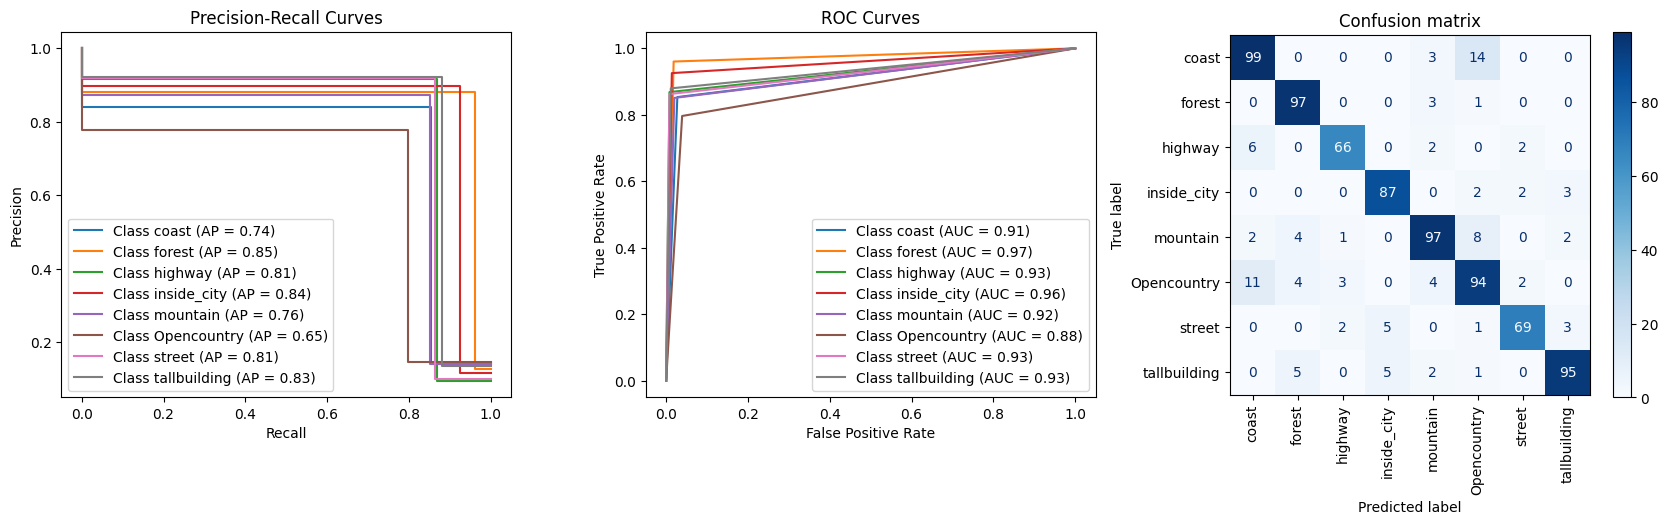

In [14]:
plot_test_eval(test_labels, predictions)

If we take a look at the PR and ROC curves we can see that both graphics present a similar picture: The model performs very similar along all the classes, which indicates that is not heavily biased towards a specific class. 

To better understand which are the classes that the model has more problems with, we should look at the PR curve, since our dataset is slightly unbalanced and therefore the ROC curve might be misleading. There, we can see that classes 

By looking at the Confusion matrix we can see how, surprisingly, the model tends to misclassify "forest" instances as "coast" and viceversa. In fact, the two first columns have the largest values of all the table (outside the diagonal), which might indicate that are harder to characterize with our features.

#### 12.2. Qualitative analysis

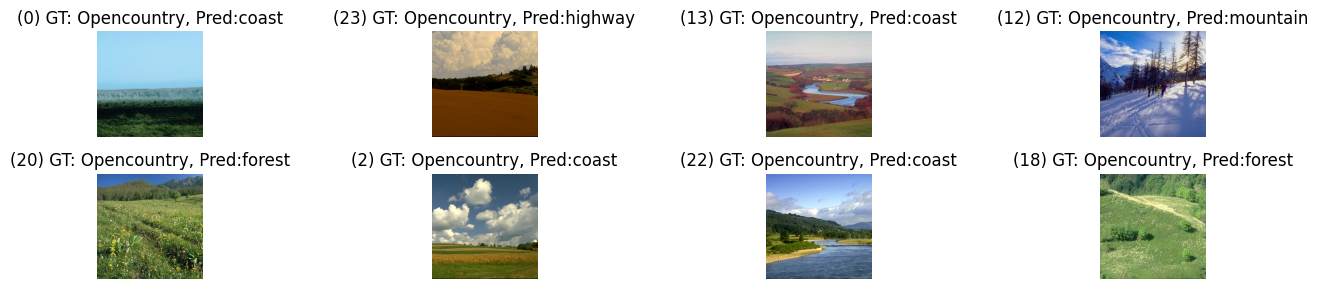

In [24]:
# Opencountry instances that the model confuses with other classes
labels_array = np.array(test_labels)
preds = predictions[labels_array == "Opencountry"][predictions[labels_array == "Opencountry"] != "Opencountry"]
gt = labels_array[labels_array == "Opencountry"][predictions[labels_array == "Opencountry"] != "Opencountry"]
images = np.array(test_images_filenames)[labels_array == "Opencountry"][predictions[labels_array == "Opencountry"] != "Opencountry"]

num_samples = 8

all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 4, preds=preds, show_gt_pred=True)


Above, we see multiple examples where the model has predicted wrongfully that the images belonged to Opencountry.

We can quickly realize that the actual problem with this class is that it is very ambiguous, and most of the predictions really make sense, per example when “mountain” has been predicted.

Although for this particular class this is specially obvious, this is common to most classes: we cannot expect a perfect performance in a task that even humans would fail.

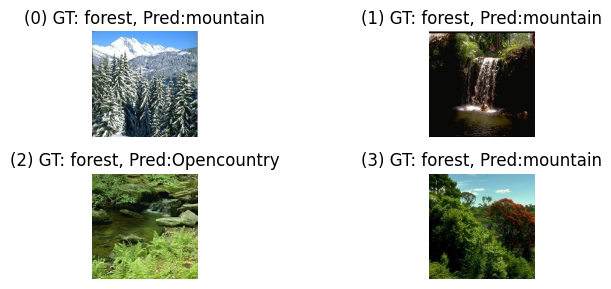

In [19]:
# Forest  instances that the model confuses with other classes
labels_array = np.array(test_labels)
preds = predictions[labels_array == "forest"][predictions[labels_array == "forest"] != "forest"]
gt = labels_array[labels_array == "forest"][predictions[labels_array == "forest"] != "forest"]
images = np.array(test_images_filenames)[labels_array == "forest"][predictions[labels_array == "forest"] != "forest"]

all_indices = list(range(len(preds)))
visualize_images(images, gt, all_indices, 2, preds=preds, show_gt_pred=True)


Now we have well predicted samples of the class Forest, which the model is able to characterize and classify swiftly.

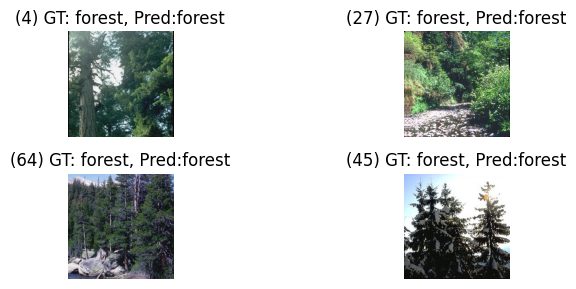

In [22]:
# Forest instances predicted correctly
labels_array = np.array(test_labels)
preds = predictions[labels_array == "forest"][predictions[labels_array == "forest"] == "forest"]
gt = labels_array[labels_array == "forest"][predictions[labels_array == "forest"] == "forest"]
images = np.array(test_images_filenames)[labels_array == "forest"][predictions[labels_array == "forest"] == "forest"]

num_samples = 4
all_indices = list(range(len(preds)))
random_indices = random.sample(all_indices, num_samples)
visualize_images(images, gt, random_indices, 2, preds=preds, show_gt_pred=True)


And now we show the only four samples of the same Forest class where the model has failed, and right away we can see multiple cases of ambiguity, in the (0) and (2) examples, where the predicted label makes sense but is different to the ground truth.

### 13. Exploring many parameters at the same time

KNN

In [ ]:
# Define the objective function (classification accuracy)
def objective(trial):
    n_features = trial.suggest_int('n_features', 50, 2000)
    step_size = trial.suggest_int('step_size', 1, 100)
    scale_factor = trial.suggest_int('scale_factor', 2, 20)
    normalize = trial.suggest_categorical('normalize', [True, False])
    scale = trial.suggest_categorical('scale', [True, False])
    k_codebook = trial.suggest_int('k_codebook', 150, 400)
    k_neigh = trial.suggest_int('k_neigh', 2, 100)
    pyramid_level = trial.suggest_int('pyramid_level', 0, 4, step=1)
    n_components = trial.suggest_int('n_components', 1, 149, step=1)
    dim_reduction = trial.suggest_categorical('dim_reduction', ["pca", "lda"])

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': n_features,
            'k_codebook': k_codebook,
            'step_size': step_size,
            'scale_factor': scale_factor,
            'k_neigh': k_neigh,
            'distance': 'euclidean',
            'n_folds': 4,
            'normalize': normalize,
            'scale': scale, 
            'dim_reduction': dim_reduction,
            'n_components': n_components,
            'model_type': "knn",
            'pyramid_level': pyramid_level
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'n_features': n_features, 'step_size': step_size, 'scale_factor': scale_factor, 'normalize': normalize, 'scale': scale, 'k_codebook': k_codebook, 'pyramid_level': pyramid_level, 'n_components': n_components, 'dim_reduction': dim_reduction, 'k_neigh': k_neigh, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='KNN full model optimization')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

/home/tda/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


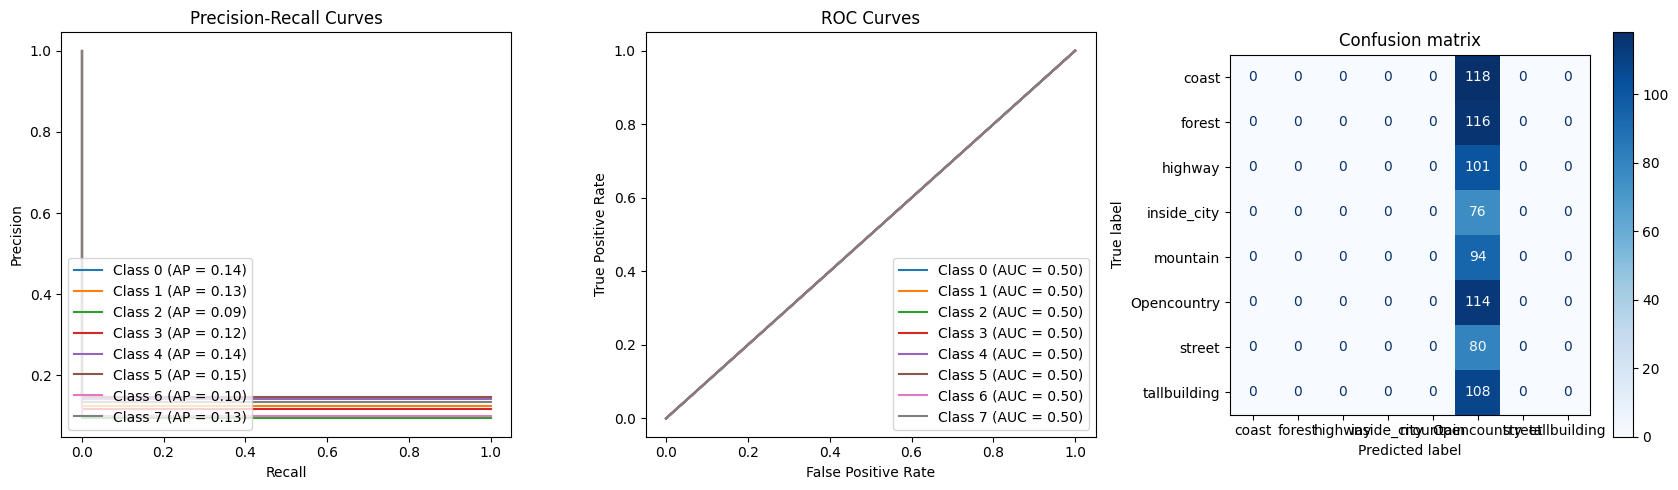

In [8]:
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 1372,
            'k_codebook': 321,
            'k_neigh': 33,
            'step_size': 10,
            'scale_factor': 15,
            'distance': 'jaccard',
            'normalize': None,
            'scale': True,
            'model_type': 'knn',
            'dim_reduction': "lda",
            'n_components': 140,
            'pyramid_level': 0
        }

accuracy, precision, recall, f1_score, predictions = test_model(train_images_filenames, train_labels, test_images_filenames, test_labels, config)
plot_test_eval(test_labels, predictions)

LOGISTIC REGRESSION

In [ ]:
# Define the objective function (classification accuracy)
def objective(trial):
    n_features = trial.suggest_int('n_features', 50, 2000)
    step_size = trial.suggest_int('step_size', 1, 100)
    scale_factor = trial.suggest_int('scale_factor', 2, 20)
    normalize = trial.suggest_categorical('normalize', [True, False])
    scale = trial.suggest_categorical('scale', [True, False])
    k_codebook = trial.suggest_int('k_codebook', 150, 400)
    C = trial.suggest_float('C', 0.001, 1000, step=None, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])
    pyramid_level = trial.suggest_int('pyramid_level', 0, 4, step=1)
    n_components = trial.suggest_int('n_components', 1, 149, step=1)
    dim_reduction = trial.suggest_categorical('dim_reduction', ["pca", "lda"])

    config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': n_features,
            'k_codebook': k_codebook,
            'step_size': step_size,
            'scale_factor': scale_factor,
            'distance': None,
            'n_folds': 4,
            'normalize': normalize,
            'scale': scale,
            'dim_reduction': dim_reduction,
            'n_components': n_components,
            'model_type': "logistic_regression",
            'C': C,
            'penalty': penalty,
            'fit_intercept': fit_intercept,
            'solver': solver,
            'pyramid_level': pyramid_level
        }
        
    accuracy, precision, recall, f1_score = cross_validation(train_images_filenames, train_labels, config)
    
    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({'n_features': n_features, 'step_size': step_size, 'scale_factor': scale_factor, 'normalize': normalize, 'scale': scale, 'k_codebook': k_codebook, 'pyramid_level': pyramid_level, 'n_components': n_components, 'dim_reduction': dim_reduction, 'C': C, 'penalty': penalty, 'fit_intercept': fit_intercept, 'solver': solver, 'f1-score': f1_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
    
    return f1_score

# Initialize Weights & Biases
wandb.init(project='c3_2', name='Logistic regression full model optimization')

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50, n_jobs=-1)

# Access the best trial and its parameters
best_trial = study.best_trial

# Print the results
print('Best trial:')
print('F1-Score: ', best_trial.value)
print('Params: ', best_trial.params)

wandb.finish()

/home/tda/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


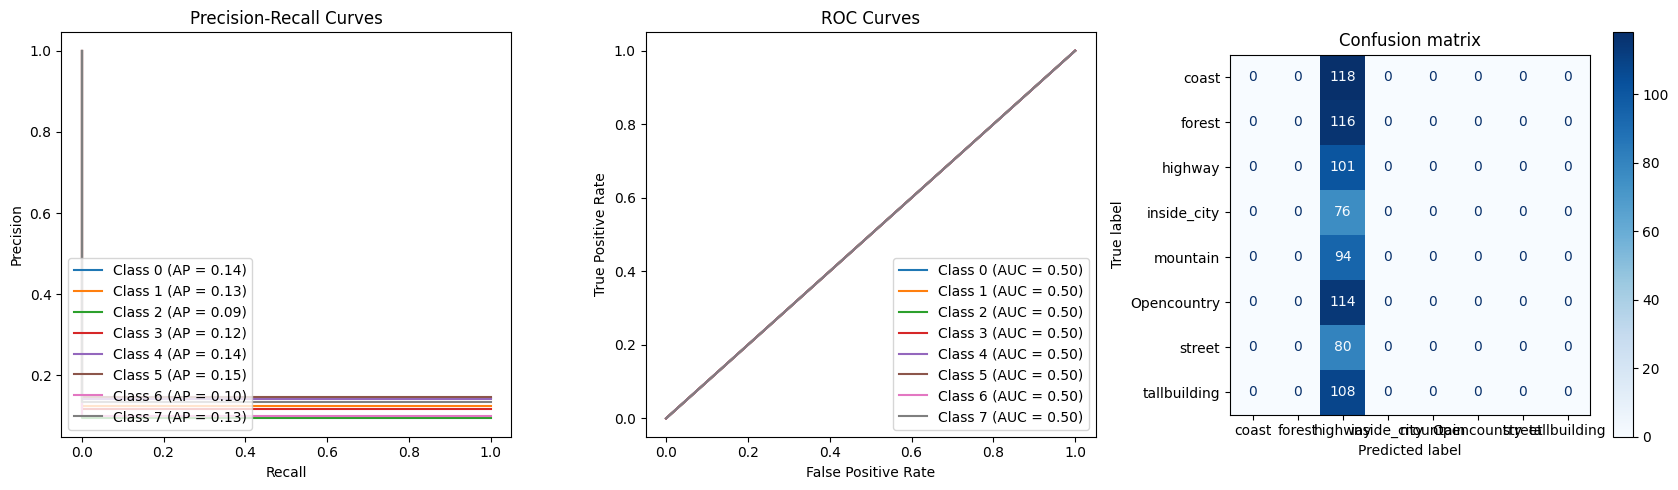

In [10]:
config = {
            'descriptor': 'dense_SIFT',
            'descriptor_param': 1112,
            'k_codebook': 173,
            'k_neigh': 10,
            'step_size': 59,
            'scale_factor': 17,
            'distance': 'jaccard',
            'normalize': None,
            'scale': True,
            'C': 0.0061719203687365534,
            'penalty': 'none',
            'model_type': 'knn',
            'dim_reduction': "lda",
            'n_components': 6,
            'pyramid_level': 0, 
            'fit_intercept': True,
            'solver': 'saga',
        }

accuracy, precision, recall, f1_score, predictions = test_model(train_images_filenames, train_labels, test_images_filenames, test_labels, config)
plot_test_eval(test_labels, predictions)

For this last section our aim is to benefit from the intelligent search of optuna and optimize all the parameters at the same time in order to compare this result with our previous conclusions. Our expectations were high and we did not obtain any reasonable model that could be compared with our SOTA model (Section 12). This could be explained by many reasons, but the main reason is the computational cost. We wanted to realize at least 50 trials for every experiment, and we broadly arrived to 20 due to our hardware limitations. The result models are not solving the classification problem at all and this can be clearly seen in the confusion matrix, precision-recallcurves and ROC curves. 